# Copula Demo

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [10]:
rho = 0.3
Z2 = np.random.normal(size=(1000,2))
Z2[:,1] = Z2 @ np.array([rho, np.sqrt(1-rho**2)])

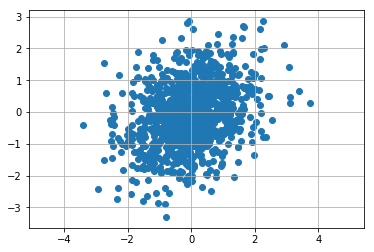

In [11]:
# Plot on the domain of normal distribution [-infty, infty]
plt.scatter(Z2[:,0], Z2[:,1])
plt.axis('equal')
plt.grid()
plt.show()

In [12]:
Z2

array([[-0.67686963, -0.96461042],
       [ 0.92587333, -0.17052364],
       [ 1.18623246, -0.56779872],
       ...,
       [ 0.57570613,  0.37832945],
       [ 0.42669035,  0.24000218],
       [ 1.16660192,  0.9661302 ]])

In [13]:
U2 = ss.norm.cdf(Z2)
U2

array([[0.24924434, 0.16736999],
       [0.82274409, 0.43229917],
       [0.88223474, 0.28508582],
       ...,
       [0.71759309, 0.64740706],
       [0.66519756, 0.59483572],
       [0.87831442, 0.83301048]])

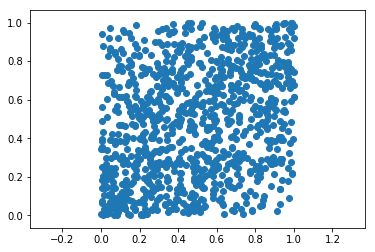

In [14]:
# Plot on the domain of uniform distribution [0,1]
plt.scatter(U2[:,0], U2[:,1])
plt.axis('equal')
plt.show()

In [15]:
# Now use the joint pair (U1, U2) pair to the default rate
lam = 1
default = -np.log(U2)/lam

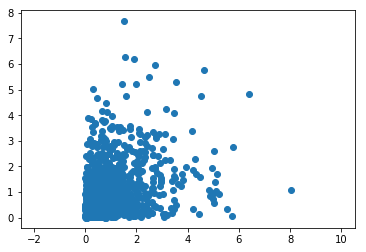

In [16]:
plt.scatter(default[:,0], default[:,1])
plt.axis('equal')
plt.show()

## We create a Gaussian copula function

In [17]:
def CopulaGaussian(n_var=2, n_sample=1000, rho=0.0):
    corr_mat = np.eye(n_var)*(1-rho) + rho
    chol_mat = np.linalg.cholesky(corr_mat)
    Z = np.random.normal(size=(n_sample, n_var)) @ chol_mat.transpose()
    U = ss.norm.cdf(Z)
    return U

In [21]:
U2 = CopulaGaussian(rho=0.9)

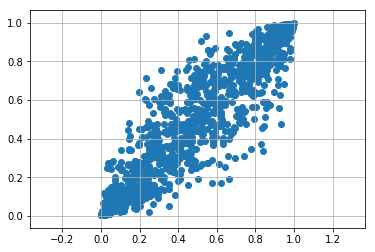

In [22]:
# Test the code
plt.scatter(U2[:,0], U2[:,1])
plt.axis('equal')
plt.grid()
plt.show()

# Simple CDO demo

##### * Assume that the individual loans have the default rate of $\lambda$=0.3 (30% of loans default every year)
* Let's package 10 (possibly sub-prime) loans into our CDO
* Create gaussian copula with rho = 0.5 vs 0.9
* Assume the maturity of our CDO is 1 year. 
* Assume the senior tranche is the bottom 50% of the loan (i.e. not affected by the first 50% loss)

In [73]:
# Gaussian copula 
lam = 0.3
n_sample=10000
U2 = CopulaGaussian(n_var=10, n_sample=n_sample, rho=0.5)

# Generate RNs for the default time
default_time = -np.log(U2)/lam
default_time

array([[ 6.94068045,  0.89515778,  2.11372289, ...,  3.31761079,
         4.58890154,  7.37846087],
       [ 0.63617078,  0.30873451,  0.35576156, ...,  0.22364751,
         1.1604675 ,  0.28413471],
       [ 0.25607221,  2.11195781,  2.54517783, ...,  2.4737102 ,
         0.97586605,  1.09070391],
       ...,
       [ 1.4532626 ,  0.72108587,  0.14913504, ...,  0.12463013,
         2.30472285,  0.55882736],
       [11.55565293,  3.5199661 ,  1.12645956, ...,  0.48338884,
         6.2530309 ,  7.17191702],
       [ 1.34903215,  3.942786  ,  7.11865309, ...,  2.72577959,
         2.68646428,  6.91144929]])

In [74]:
# Check that the average default time of the individual loans are around 5 years
print( np.mean(default_time, axis=0) )

[3.35724633 3.35863492 3.36239603 3.35031896 3.36218762 3.35272488
 3.33551106 3.3544577  3.36139856 3.35009494]


In [76]:
# Compute the default ratio for the individual loans within 1 year
# it should be about 20%. Exactly 1-exp(-0.2)
print( "Exact default rate < 1yr:", 1 - np.exp(-lam) )
print( np.sum(default_time < 1.0, axis=0) / n_sample )

Exact default rate < 1yr: 0.2591817793182821
[0.2567 0.2633 0.2664 0.2621 0.2611 0.2602 0.264  0.2641 0.2593 0.2601]


In [77]:
# Expected of individual loan
(1 - np.sum(default_time < 1.0, axis=0) / n_sample)*100

array([74.33, 73.67, 73.36, 73.79, 73.89, 73.98, 73.6 , 73.59, 74.07,
       73.99])

In [78]:
# Count the total defaults in the pool within 1 year
default_total_loan = np.sum(default_time < 1.0, axis=1)
print( default_total )

[2 3 1 ... 0 0 0]


In [79]:
# Compute the percentage of the total default bigger than 4
# This is the probability of the senior tranche having any loss
sum(default_total_loan > 5)/n_sample

0.1751

In [80]:
# We can also compute the expected price of senior tranche (out of 100)
np.mean(np.fmin(10-default_total_loan,5))/5.0 * 100

91.34

## When the correlation is high, the default rate of the senior tranche CDO is just as bad as the individual loans (sub-prime)